In [1]:
from entity_gym.sample_recorder import Trace
from entity_gym.environment import Action
import matplotlib.pyplot as plt
import math
import numpy as np
import tqdm

In [2]:
#path = "enn/220117-200712-2snake-sampletest-3e04f0904caa4c98868c96b69fb2ab37/sample.blob"
path = "enn/220118-043819-2snake-sampletest-b0a8ec8aaec0457c8050f3e42c7153a8/sample.blob"
trace = Trace.deserialize(open('/mnt/a/Dropbox/artifacts/xprun/' + path, 'rb').read(), progress_bar=True)
job_name = "-".join(path.split('/')[1].split('-')[:-1])

  0%|          | 0/287969450 [00:00<?, ?it/s]/home/clemens/.cache/pypoetry/virtualenvs/incubator-Qe8CM38i-py3.8/lib/python3.8/site-packages/msgpack_numpy.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b'nd' in obj:
/home/clemens/.cache/pypoetry/virtualenvs/incubator-Qe8CM38i-py3.8/lib/python3.8/site-packages/msgpack_numpy.py:96: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif b'complex' in obj:
100%|██████████| 287969450/287969450 [00:14<00:00, 20121754.20it/s]


In [3]:
from dataclasses import dataclass
from entity_gym.environment import ObsBatch
from ragged_buffer import RaggedBufferF32, RaggedBufferI64
from typing import List, Tuple, Dict, Optional, Any

@dataclass
class Episode:
    number: int
    steps: int
    entities: Dict[str, RaggedBufferF32]
    actions: Dict[str, List[Action]]
    logprobs: Dict[str, RaggedBufferF32]
    logits: Dict[str, RaggedBufferF32]
    total_reward: float
    complete: bool = False

In [4]:
complete_episodes = trace.episodes(progress_bar=True)

100%|██████████| 864/864 [00:22<00:00, 38.87it/s]


In [5]:
#print(len(episodes))
print(len(complete_episodes))
#print(trace.samples[0])

111476


In [6]:
trace.samples[3].logits

{'move': RaggedBuffer([
     [
         [-0.010891112, 0.012103668, -0.016685575, 0.0007153817],
         [-0.018220192, -0.0049487185, -0.018265793, 0.0013074302],
     ],
     [
         [-0.0018205123, 0.008287921, -0.012610463, 0.006722744],
         [-0.02641407, 0.0080894055, -0.017509582, 0.0015216279],
     ],
     [
         [-0.0111437235, 0.011756734, -0.016714955, 0.00023485231],
         [-0.017721793, -0.0015262729, -0.014485516, 0.0008225974],
     ],
     [
         [-0.0056506675, 0.009563197, -0.014704925, 0.0051279617],
         [-0.021345511, -0.0010174974, -0.018967785, 0.0025028854],
     ],
     [
         [-0.007684932, 0.011079032, -0.015565515, 0.0029519151],
         [-0.026137568, 0.010229125, -0.022930797, 0.0028208876],
     ],
     [
         [0.0055880807, 0.0024586278, 0.019325402, 0.016746704],
         [0.0013154099, 0.0070647895, 0.01059188, 0.002698801],
     ],
     [
         [-0.021895504, -0.0012614715, 0.0001267204, 0.014128936],
         [0.02

In [7]:
#suss_episodes = []
#for e in episodes.values():
#    if e.number > len(episodes) * 0.95 and e.number < len(episodes) - 512 and e.total_reward < 0.85:
#        # print(e.number, e.steps, e.total_reward)
#        suss_episodes.append(e)

In [8]:
complete_episodes[-1].complete

True

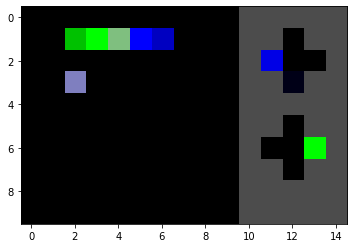

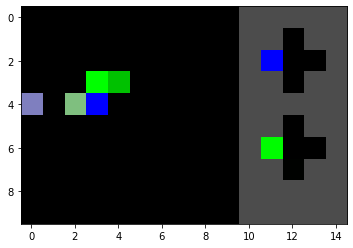

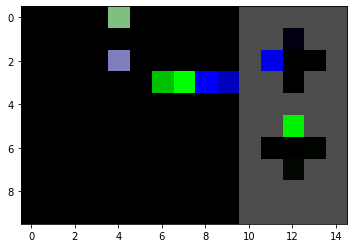

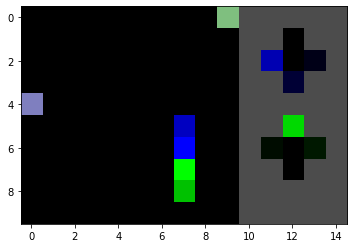

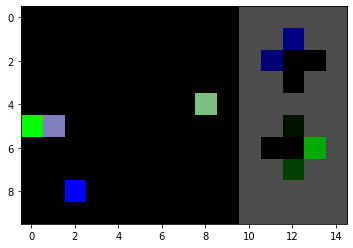

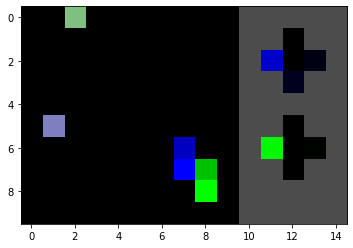

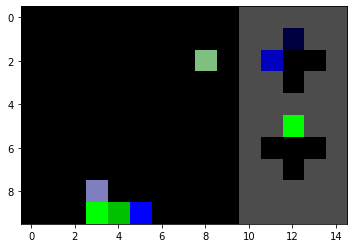

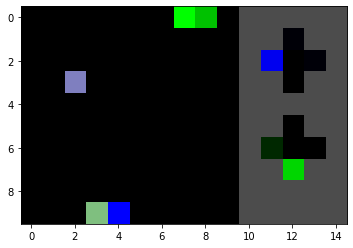

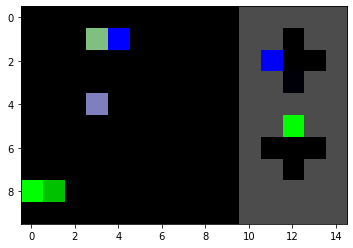

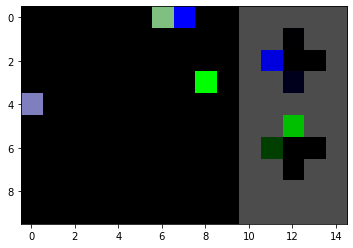

In [9]:
%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

from collections import defaultdict

def render_episode(episode: Episode, translate: bool, color_logits: bool = True):
    imgs = []
    frames = []
    for step in range(episode.entities["SnakeHead"].size0() + 10):
        if step > episode.entities["SnakeHead"].size0() - 1:
            step = episode.entities["SnakeHead"].size0() - 1
        img = np.zeros((10, 15, 3), dtype=np.float32)
        img[:, 10:, :] = [0.3, 0.3, 0.3]
        heads = episode.entities["SnakeHead"][step].as_array()
        for i, head in enumerate(heads):
            head_x = int(head[0])
            head_y = int(head[1])
            color = [0, 0, 1] if head[2] == 0 else [0, 1, 0]
            img[head_y, head_x, :] = color
            if translate:
                ox, oy = head_x, head_y
            else:
                ox, oy = 0, 0
            #img[int(heads[1][0]), int(heads[1][1]), :] = [0, 1, 0]
        n_segments = defaultdict(lambda: 0)
        for segment in reversed(episode.entities["SnakeBody"][step].as_array()):
            n_segments[segment[2]] += 1
            x = int(segment[0]) + ox
            y = int(segment[1]) + oy
            intensity = 0.8 - n_segments[segment[2]] * 0.04
            color = [0, 0, intensity] if segment[2] == 0 else [0, intensity, 0]
            img[y, x, :] = color
        for food in episode.entities["Food"][step].as_array():
            x = int(food[0]) + ox
            y = int(food[1]) + oy
            color = [0.5, 0.5, 0.75] if food[2] == 0 else [0.5, 0.75, 0.5]
            img[y, x, :] = color
        
        for i, ((actor, action), prob) in enumerate(zip(
            episode.actions["move"][step].actions,
            np.exp(episode.logprobs["move"][step].as_array()))
        ):
            logits = episode.logits["move"][step].as_array()[i]
            for a in range(4):
                img[2 + i * 4, 12, :] = [0, 0, 0]
                probs = np.exp(logits) / np.sum(np.exp(logits))
                prob = probs[a]
                if a == action or color_logits:
                    color = [0, 0, float(prob)] if i == 0 else [0, float(prob), 0]
                else:
                    color = [float(prob), float(prob), float(prob)]
                if a == 0: # up
                    img[3 + i * 4, 12, :] = color
                elif a == 1: # down
                    img[1 + i * 4, 12, :] = color
                elif a == 2: # left
                    img[2 + i * 4, 11, :] = color
                elif a == 3: # right
                    img[2 + i * 4, 13 , :] = color

        imgs.append(img)
    fig = plt.figure()
    for img in imgs:
        frames.append([plt.imshow(img, animated=True)])

    ani = animation.ArtistAnimation(fig, frames, interval=250, blit=True,
                                    repeat_delay=1000, repeat=True)
    ani.save(f'videos/{job_name}-{e.number}.mp4')
    #plt.show()

#render_episode(episodes[len(episodes)-1024], True)
#render_episode(episodes[101832 ], True)
#for e in suss_episodes[:10]:
#start = int(0.95*len(episodes))
clear = True
if clear:
    # delete all videos
    import os
    for f in os.listdir(f'videos/'):
        os.remove(f'videos/{f}')
for e in complete_episodes[-110:-100]:
    render_episode(e, False)# True)

In [10]:
print("-".join(path.split('/')[1].split('-')[:-1]))

220118-043819-2snake-sampletest
